In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.analysis.analysis_roc as ar

setGPU: Setting GPU to: 2


In [2]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [3]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((5*10e3//batch_size)*batch_size)

In [4]:
nodes_n, feat_sz, particles_bg  = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 98135
Number of constituents (nodes) = 50
Number of features = 3


In [5]:

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
valid_set_size = int((10e3//batch_size)*batch_size)
_,_, particles_bg_valid = prepr.prepare_data_constituents(filename_bg_valid,valid_set_size,0,valid_set_size+1)



Number of jets = 19650
Number of constituents (nodes) = 50
Number of features = 3


In [6]:
#BG test
_,_, particles_bg_test = prepr.prepare_data_constituents(filename_bg_valid,5000,valid_set_size+1,valid_set_size+5000)


Number of jets = 9840
Number of constituents (nodes) = 50
Number of features = 3


In [7]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


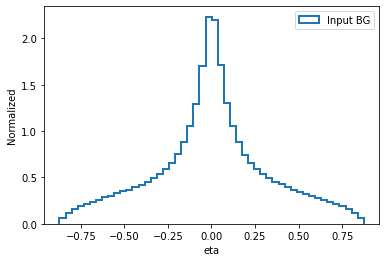

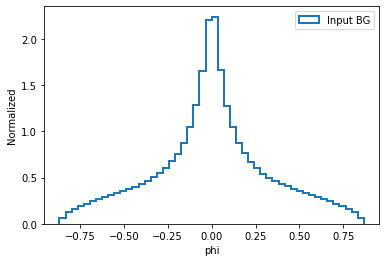

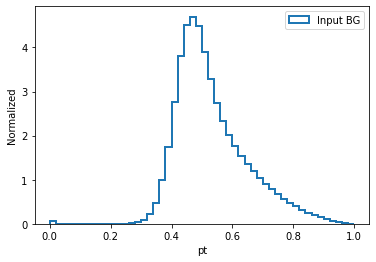

In [8]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    #plt.semilogy()
    plt.show()

# Particle Net AE

In [29]:
import models.PNmodel as pn
reload(pn)

<module 'models.PNmodel' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/PNmodel.py'>

In [30]:
input_shapes = {}
input_shapes['points'] =  [nodes_n,feat_sz-1] #using only coordinates eta phi
input_shapes['features'] = [nodes_n,feat_sz]
input_shapes['mask'] = None
model = pn.get_particle_net_lite_ae(input_shapes)
model.summary()

64
Model: "ParticleNetAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_40 (Tenso [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_71 (Tens [(None, 50, 1, 3)]   0           features[0][0]                   
___________________________________________________________________________________

In [31]:
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

optim = Adam(learning_rate=0.001)

# Compile the Model
model.compile(optimizer=optim, loss=losses.threeD_loss)
#model.compile(optimizer=optim, loss='mse')

In [ ]:

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

history = model.fit((particles_bg[:,:,0:2], particles_bg) , particles_bg,
                    validation_data = ((particles_bg_valid[:,:,0:2], particles_bg_valid) , particles_bg_valid),
                    epochs=3, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls]) 

Epoch 1/3
390/390 [==============================] - 8s 22ms/step - loss: 0.0301 - val_loss: 0.0302
Epoch 2/3
390/390 [==============================] - 8s 20ms/step - loss: 0.0229 - val_loss: 0.0225
Epoch 3/3
223/390 [================>.............] - ETA: 3s - loss: 0.0211

In [39]:

loaded_model = tf.keras.models.load_model(
    "/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_model_saved_PN_AE_2021_07_29_T_11_22",
    custom_objects={"PN_AE": pn.get_particle_net_lite_ae, "threeD_loss":losses.threeD_loss}
)



In [40]:
model = loaded_model

Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
Y_sig_predict = model.predict([particles_sig[:,:,0:2],particles_sig])

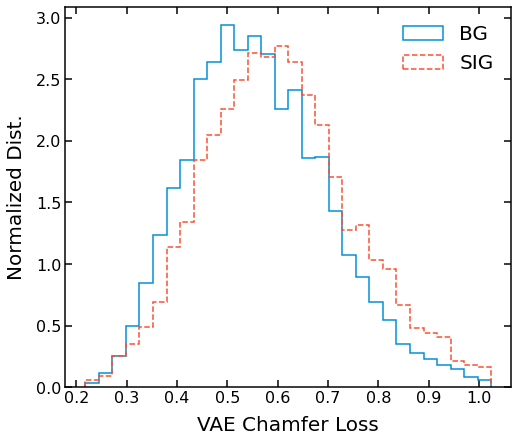

In [41]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_sig,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_ae.pdf'
plt.savefig(savename)
plt.show()

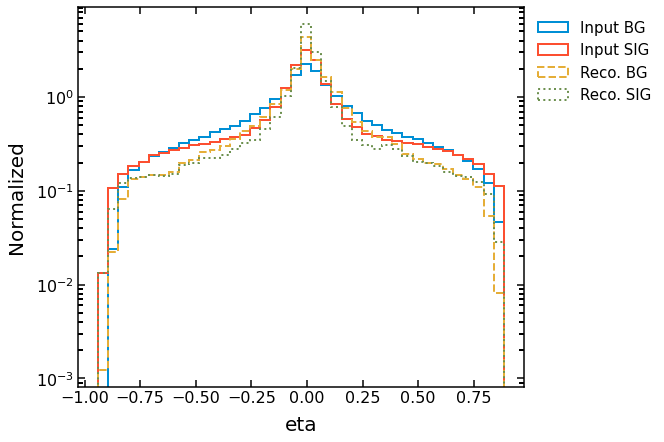

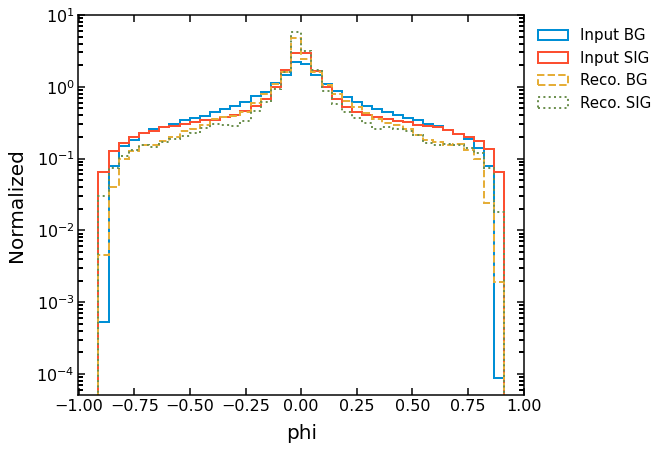

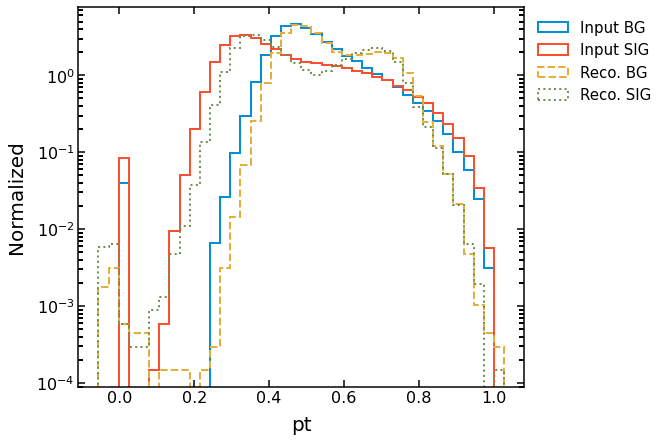

In [42]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_ae_{}_test.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


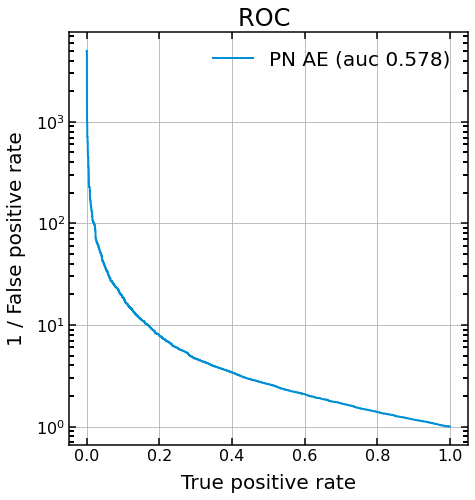

[0.57845102]

In [43]:
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist()]

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['PN AE'], title='ROC ',
            plot_name='ROC_pnae_test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )
